<a href="https://colab.research.google.com/github/danielTobon43/face_detection_mtcnn/blob/main/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------<br>

# OpenCV and Deep Learning Stage
<br>
In this stage you will be using OpenCV and MTCNN (https://pypi.org/project/mtcnn/). <br>
This MTCNN is an opensource implementation of the original Paper https://github.com/davidsandberg/facenet/tree/master/src/align on Python. Also, this implementation runs on the top of Keras (2.3+) and TensorFlow (2+). We are going to take advantage of Google Colab for this 2 last requirements, because all of that comes pre-installed. <br>
In this test we give you a cropped video of The Beatles from the song Something. Your mission consists in reading all frames of the video, doing inference in each frame, drawing in frame the metadata and then creating a new video from the frames processed. Using the detection from MTCNN you will be able to get face, eyes, mouth and nose points. <br>
The following is an example of a basic use of MTCNN and also the metadata you can get:

```python
from mtcnn import MTCNN
import cv2
img = cv2.cvtColor(cv2.imread("frame.jpg"), cv2.COLOR_BGR2RGB)
detector = MTCNN()
detector.detect_faces(img)
[
    {
        "box": [277, 90, 48, 63],
        "keypoints":
        {
            "nose": (303, 131),
            "mouth_right": (313, 141),
            "right_eye": (314, 114),
            "left_eye": (291, 117),
            "mouth_left": (296, 143)
        },
        "confidence": 0.99851983785629272
    }
]
```

With the metadata obtained from MTCNN per face detected, you have to: <br>
    * Draw face bounding box and the confidence on the top of it <br>
    * Draw eyes points <br>
    * Draw mouth points <br>
    * Draw nose point <br><br>
Also, per frame analyzed you are asked to draw-in-frame the following information of the frame:<br>
    * Number of faces detected<br>
    * Number of eyes, mouth and nose detected.<br>
    * Number of the frame analyzed.<br>
    * This information can be written at the sides of the video (you will see that the video has some black bars at the sides). <br>
    * **Be careful with some false positive faces!** You are asked to draw **only real faces**. You must do a validation in which those fake faces don't appear in your drawings.<br><br>
You have to save all frames analyzed and then **create a new video** from the frames saved. You are free to create this video with any tool you want, like OpenCV, ffmpeg, GStreamer...<br>
As an example, this is how a single frame must look like:
![example_cv2](https://public-research-spot.s3.amazonaws.com/dl_py_challenge/img/example_cv2.jpg)<br>
And once again **your're free of choosing the colors you like** and good luck! <br>

**Bonus points**: you will get bonus points if you are able to:<br>
* add a *tracking* method per face detected. This means that every face detected will get an *id*.
* recognize each member of The Beatles, using any face recognition tool.
* recognize per face detected its emotion (happy, sad, angry, confused, etc.).
* If add any other feature in this test!

   

In [ ]:
# run this cell to install mtcnn
!pip3 install mtcnn dataclasses

     |████████████████████████████████| 2.3 MB 5.5 MB/s 


In [ ]:
# run this cell to obtain the video
!wget https://public-research-spot.s3.amazonaws.com/dl_py_challenge/video/extractBeatles.mp4

--2022-04-09 13:18:47--  https://public-research-spot.s3.amazonaws.com/dl_py_challenge/video/extractBeatles.mp4
Resolving public-research-spot.s3.amazonaws.com (public-research-spot.s3.amazonaws.com)... 52.217.43.12
Connecting to public-research-spot.s3.amazonaws.com (public-research-spot.s3.amazonaws.com)|52.217.43.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38090824 (36M) [video/mp4]
Saving to: ‘extractBeatles.mp4’

extractBeatles.mp4  100%[===================>]  36.33M  52.6MB/s    in 0.7s    

2022-04-09 13:18:48 (52.6 MB/s) - ‘extractBeatles.mp4’ saved [38090824/38090824]



# import libraries

In [ ]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, field
import cv2

# Dataclass to handle common data
This section define a dataclass to store matadata from an image and a video file

## Documentation
https://docs.python.org/3/library/dataclasses.html

In [ ]:
@dataclass
class ImageMetadata:
  """ class for keeping metadata associate to the image """
  fame_id: int = 0
  eyes: int = 0
  faces: int = 0
  nose: int = 0
  mouth: int = 0

@dataclass
class VideoMetadata:
  """ class for keeping metadata associate to the video file """
  video: cv2.VideoCapture = field(init=False)
  number_of_frames: int = 0
  frame_width: int = 0
  frame_height: int = 0
  frames_per_second: float = 0
  mouth: int = 0
  duration: int = 0.0
  size: tuple = field(default_factory=tuple)

# OpenCV drawing functions
This section define functions to draw text, boxes and circles in an image.

## Documentation
https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html

In [ ]:
def draw_bounding_box_on_image(image: np.ndarray, box: np.ndarray) -> None:
  cv2.rectangle(image,box,(0,255,0),6)

def draw_eyes_on_image(image: np.ndarray, left_eye: int, right_eye: int) -> None:
  cv2.circle(image,left_eye, 10, (255,0,0), -1)
  cv2.circle(image,right_eye, 10, (255,0,0), -1)

def draw_nose_on_image(image: np.ndarray, nose_center: tuple) -> None:
  cv2.circle(image,nose_center, 10, (0,0,255), -1)

def draw_lips_on_image(image: np.ndarray, mouth_left: int, mouth_right: int) -> None:
  cv2.circle(image,mouth_left, 10, (255,0,255), -1)
  cv2.circle(image,mouth_right, 10, (255,0,255), -1)

def draw_text_confidence_on_image(image: np.ndarray, confidence: float, center: tuple) -> None:
  text_thickness = 2
  cv2.putText(image, f"Confidence: {confidence:.4f}", (center[0], center[1]), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

def draw_metadata_on_image(image: np.ndarray, metadata: ImageMetadata) -> None:
  text_thickness = 2
  cv2.putText(image, 'metadata:', (0, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), text_thickness)
  cv2.putText(image, f'faces: {metadata.faces}', (0, 130), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), text_thickness)
  cv2.putText(image, f'eyes: {metadata.eyes}', (0, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), text_thickness)
  cv2.putText(image, f'nose: {metadata.nose}', (0, 190), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), text_thickness)
  cv2.putText(image, f'mouth: {metadata.mouth}', (0, 220), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), text_thickness)
  cv2.putText(image, f'Number of frame: {metadata.frame_id}', (0, 250), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), text_thickness)

  # rectangle around confidence text
  # cv2.rectangle(((x1, y1 - text_height), (x1 + text_width, y1)), fill='white')
  # cv2.putText((x1, y1 - text_height), f'{name}: {confidence:.2f}', (225, 255, 255), font)

In [ ]:
def draw_on_image(frame: np.ndarray, box: np.ndarray, confidence: float, keypoints: dict, image_metadata: ImageMetadata) -> None:
  """ function to apply drawing functions to image """
  # draw rectangle on face
  draw_bounding_box_on_image(frame, box)

  # draw circle in the nose
  draw_nose_on_image(frame, keypoints['nose'])

  # draw circle in the eyes
  draw_eyes_on_image(frame, keypoints['left_eye'], keypoints['right_eye'])

  # draw circle on lips
  draw_lips_on_image(frame, keypoints['mouth_left'], keypoints['mouth_right'])

  # draw confidence
  draw_text_confidence_on_image(frame, confidence, box)

  # draw metadata information
  draw_metadata_on_image(frame, image_metadata)

# Video processing functions
This section define functions to handle a video.


In [ ]:
def preprocess_video(path: str) -> VideoMetadata:
  # read video file
  video = cv2.VideoCapture(path)
   
  # Check if camera opened successfully
  if not video.isOpened(): 
    print("Error opening video file")

  # initialize video metadata instance object
  video_metadata = VideoMetadata()

  # store metadata information
  video_metadata.number_of_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  video_metadata.frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
  video_metadata.frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
  video_metadata.frames_per_second = float(video.get(cv2.CAP_PROP_FPS))
  video_metadata.duration = video_metadata.number_of_frames / video_metadata.frames_per_second
  video_metadata.size = (video_metadata.frame_width, video_metadata.frame_height)

  # store video capture object
  video_metadata.video = video

  print('-----------------------')
  print(f"-> number of frames: {video_metadata.number_of_frames}")
  print(f"-> frame width: {video_metadata.frame_width}")
  print(f"-> frame height: {video_metadata.frame_height}")
  print(f"-> frames per second: {video_metadata.frames_per_second}")
  print(f"-> duration: {video_metadata.duration}")
  print(f"-> size: {video_metadata.size}")

  return video_metadata

In [ ]:
def write_avi_video(path: str, frames_per_second: int, size: tuple) -> cv2.VideoWriter:
  """ creates a .avi video file """
  video_file = cv2.VideoWriter(path+'.avi', cv2.VideoWriter_fourcc(*'MJPG'), frames_per_second, size)  
  return video_file

In [ ]:
def write_mpfor_video(path: str, frames_per_second: int, size: tuple) -> cv2.VideoWriter:
  """ creates a .mp4 video file"""
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  video_file = cv2.VideoWriter(path+'.mp4', fourcc, frames_per_second, size, True)
  return video_file

In [ ]:
def default_video_factory(type_: str):
  """ factory design pattern to create a video_write instance of function """
  if type_ == 'avi':    
    return write_avi_video
  elif type_ == 'mp4':
    return write_mpfor_video
  else:
    raise ValueError('bad post-video type: valid avi or mp4')

# MTCNN class
Initialization of the face detector class.

The CONFIDENCE_TRESHOLD is used to filter false positives.

## Note
The official TensorFlow implementation of MTCNN works well, but the PyTorch one is faster. It achieves about 13 FPS on the full HD videos, and even up to 45 FPS on rescaled agains 10 FPS of the Tensorflow implementation

In [ ]:
CONFIDENCE_TRESHOLD = 0.98
detector = MTCNN()

# **MTCNN FACE DETECTION PIPELINE**
This section defines the pipeline to detect faces from a video file.

In [ ]:
# pre-process the video file
video = preprocess_video('extractBeatles.mp4')

# create post-process video file (.mp4 or .avi)
video_factory = default_video_factory('mp4')
result = video_factory('extractBeatles_MTCNN_faces', video.frames_per_second, video.size)

# list to store preview results
preview_results = []

# Read until video is completed
print()
print('-----------------------')
print('-> processing video...')
for frame_id in range(video.number_of_frames):
      
  # Capture frame-by-frame
  try:
    success, frame = video.video.read()
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  except cv2.error:
    continue

  # define image metadata
  image_metadata = ImageMetadata()

  # create a flag to check if frame is black
  # _black_frame = not np.any(frame)
  _black_frame = cv2.countNonZero(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)) == 0

  # check if frame is good, otherwise store it
  if frame is None or _black_frame:
    result.write(frame)
    continue

  # apply MTCNN model on image to detect faces
  detections = detector.detect_faces(frame)

  # check if detection is empty
  is_empty = not np.any(detections)

  # if empty continue to the next frame
  if is_empty:
    result.write(frame)
    continue

  # if not is_empty: interate on each detected face
  for detection in detections:

    # compute metadata from detection object
    box = detection['box']
    keypoints = detection['keypoints']
    confidence = detection['confidence']  

    # check if confidence is greater than CONFIDENCE_TRESHOLD 
    if confidence >= CONFIDENCE_TRESHOLD:

      # metadata information
      image_metadata.faces += 1
      image_metadata.eyes += 2 
      image_metadata.nose += 1 
      image_metadata.mouth += 1
      image_metadata.frame_id = frame_id

      # draw detection on image
      draw_on_image(frame, box, confidence, keypoints, image_metadata)      

      # store results to preview later
      preview_results.append(frame)      

    # store frame in post-process video file
    result.write(frame)
        
# When everything done, release the video capture object
video.video.release()
result.release()
del detector
detections = []
frame = []
print("-> the video was successfully saved")

-----------------------
-> number of frames: 1442
-> frame width: 1920
-> frame height: 1080
-> frames per second: 23.976023976023978
-> duration: 60.14341666666666
-> size: (1920, 1080)

-----------------------
-> processing video...
-> the video was successfully saved


# Processing time
The processing time for detecting faces in the` extractBeatles.mp4` is about 20 mins. This means that the MTCNN run 10 frames per second; for a total of 1442 frames the time aprox is:

`total_inference_time = 1442 * 10 seconds = 24 min`

More information about MTCNN: https://towardsdatascience.com/robust-face-detection-with-mtcnn-400fa81adc2e

# Preview Results
This section display a preview of the faces detected in the video

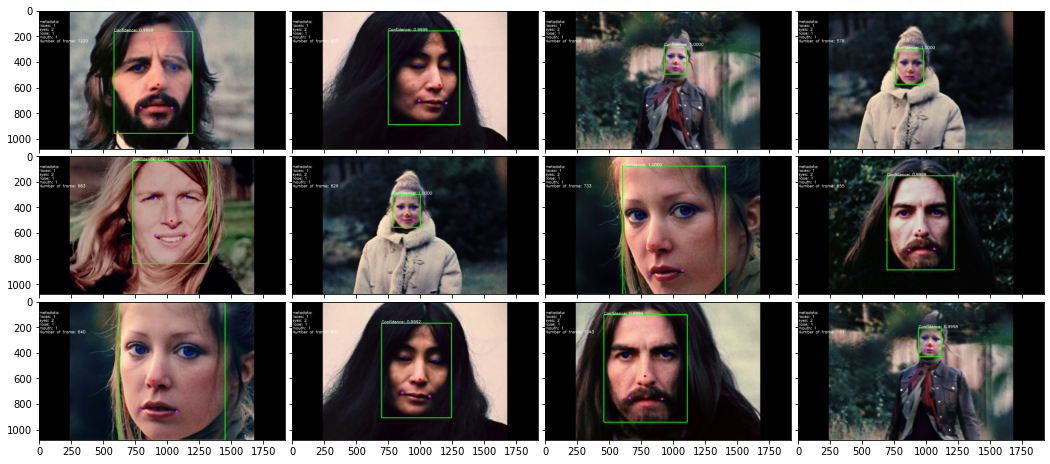

In [ ]:
%matplotlib inline
import random
from mpl_toolkits.axes_grid1 import ImageGrid

# suffle list of images
random.shuffle(preview_results)

# get 12 images from list to display
images = preview_results[::12]

# pyplot object to display an image
fig = plt.figure(figsize=(18., 9.))

# grid object to store each image
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.1)

# display 12 images in a grid
for ax, im in zip(grid, images):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

# display pyplot figure
plt.show()